In [76]:
from __future__ import annotations
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import unicodedata
from numpy.random import SeedSequence, default_rng
import ray


In [6]:
allstars = pd.read_table('all_stars_drama_raw.tsv')

In [7]:
allstars

,id,label,isGroup,gender,text,corpus,playName
0,mirvolin,Мирволин,False,MALE,"Здравствуй, Герасим! как поживаешь?.. А что, о...",rus,turgenev-zavtrak-u-predvoditelja
1,gerasim,Герасим,False,MALE,Здравствуйте. Где это вы достали лошадь?\nКто ...,rus,turgenev-zavtrak-u-predvoditelja
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja
3,velvitskij,Вельвицкий,False,MALE,"Как же-с, как же-с.\nСлушаю-с. Так, стало быть...",rus,turgenev-zavtrak-u-predvoditelja
4,alupkin,Алупкин,False,MALE,"Доложи. А-а-лупкин, дворянин…\nПокорнейше благ...",rus,turgenev-zavtrak-u-predvoditelja
...,...,...,...,...,...,...,...
34481,SAILORS.TYRE.1_Per,Sailor,False,MALE,Where is Lord Helicanus ? He can resolve you ....,shake,pericles
34482,GENTLEMEN.TYRE.0.1_Per,Gentleman,False,MALE,Doth your Lordship call ?,shake,pericles
34483,SAILORS.MYTILENE.1_Per,Sailor,False,MALE,"Sir ,\nThis is the man that can , in aught you...",shake,pericles
34484,LORDS.MYTILENE.0.1_Per,Lord,False,MALE,"Sir , we have a maid in Mytilene ,\nI durst wa...",shake,pericles


In [8]:
allstars[allstars['text'].apply(lambda x: not isinstance(x, str))]

,id,label,isGroup,gender,text,corpus,playName
10968,le-docteur-sans-pareil,Le Docteur sans Pareil,False,UNKNOWN,NaN,fre,hervilly-docteur-sans-pareil
19609,der_klavierspieler,Der Klavierspieler,False,MALE,NaN,ger,schnitzler-zum-grossen-wurstel
19860,die_anderen_1-1,Die Anderen,True,MALE,NaN,ger,anzengruber-heimgfunden
19965,ein_knappe,Ein Knappe,False,MALE,NaN,ger,hebbel-agnes-bernauer
19975,schildknapp,Ein Schildknapp,False,MALE,NaN,ger,hebbel-agnes-bernauer
...,...,...,...,...,...,...,...
32779,dritter_herr,3. Herr,False,MALE,NaN,ger,chlumberg-die-fuehrer
32921,zehnte_gruppe,Zehnte Gruppe,True,UNKNOWN,NaN,ger,chlumberg-wunder-um-verdun
33030,die_magd,Die Magd,False,FEMALE,NaN,ger,bahr-das-konzert
33548,Epilogue_2H4,Epilogue,False,UNKNOWN,NaN,shake,henry-iv-part-ii


In [9]:
# drop all rows where the text isn't a string

allstars.drop(allstars[allstars['text'].apply(lambda x: not isinstance(x, str))].index, inplace=True)

In [10]:
allstars

,id,label,isGroup,gender,text,corpus,playName
0,mirvolin,Мирволин,False,MALE,"Здравствуй, Герасим! как поживаешь?.. А что, о...",rus,turgenev-zavtrak-u-predvoditelja
1,gerasim,Герасим,False,MALE,Здравствуйте. Где это вы достали лошадь?\nКто ...,rus,turgenev-zavtrak-u-predvoditelja
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja
3,velvitskij,Вельвицкий,False,MALE,"Как же-с, как же-с.\nСлушаю-с. Так, стало быть...",rus,turgenev-zavtrak-u-predvoditelja
4,alupkin,Алупкин,False,MALE,"Доложи. А-а-лупкин, дворянин…\nПокорнейше благ...",rus,turgenev-zavtrak-u-predvoditelja
...,...,...,...,...,...,...,...
34481,SAILORS.TYRE.1_Per,Sailor,False,MALE,Where is Lord Helicanus ? He can resolve you ....,shake,pericles
34482,GENTLEMEN.TYRE.0.1_Per,Gentleman,False,MALE,Doth your Lordship call ?,shake,pericles
34483,SAILORS.MYTILENE.1_Per,Sailor,False,MALE,"Sir ,\nThis is the man that can , in aught you...",shake,pericles
34484,LORDS.MYTILENE.0.1_Per,Lord,False,MALE,"Sir , we have a maid in Mytilene ,\nI durst wa...",shake,pericles


In [12]:
def strip_punctuation(text: str) -> str:
    """
    >>> strip_punctuation(u'something')
    u'something'

    >>> strip_punctuation(u'something.,:else really')
    u'somethingelse really'
    """
    punctutation_cats = set(['Pc', 'Pd', 'Ps', 'Pe', 'Pi', 'Pf', 'Po'])
    return ''.join(x for x in text
                   if unicodedata.category(x) not in punctutation_cats)

In [13]:
def normalise_spaces(text: str) -> str:
    # by default, Python splits on any whitespace eg "a  \t\nb" -> ['a','b']
    return ' '.join(text.split()).strip()

In [14]:
strip_punctuation(normalise_spaces("Je suis      prêt à \t\tt'écouter, mon\n cher frère,")).lower()

'je suis prêt à técouter mon cher frère'

In [15]:
cleanText = allstars.text.map(lambda x: normalise_spaces(strip_punctuation(x).lower()))
allstars['cleanText'] = cleanText
allstars

,id,label,isGroup,gender,text,corpus,playName,cleanText
0,mirvolin,Мирволин,False,MALE,"Здравствуй, Герасим! как поживаешь?.. А что, о...",rus,turgenev-zavtrak-u-predvoditelja,здравствуй герасим как поживаешь а что он еще ...
1,gerasim,Герасим,False,MALE,Здравствуйте. Где это вы достали лошадь?\nКто ...,rus,turgenev-zavtrak-u-predvoditelja,здравствуйте где это вы достали лошадь кто пре...
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
3,velvitskij,Вельвицкий,False,MALE,"Как же-с, как же-с.\nСлушаю-с. Так, стало быть...",rus,turgenev-zavtrak-u-predvoditelja,как жес как жес слушаюс так стало бытьс бумаги...
4,alupkin,Алупкин,False,MALE,"Доложи. А-а-лупкин, дворянин…\nПокорнейше благ...",rus,turgenev-zavtrak-u-predvoditelja,доложи аалупкин дворянин покорнейше благодарю ...
...,...,...,...,...,...,...,...,...
34481,SAILORS.TYRE.1_Per,Sailor,False,MALE,Where is Lord Helicanus ? He can resolve you ....,shake,pericles,where is lord helicanus he can resolve you o h...
34482,GENTLEMEN.TYRE.0.1_Per,Gentleman,False,MALE,Doth your Lordship call ?,shake,pericles,doth your lordship call
34483,SAILORS.MYTILENE.1_Per,Sailor,False,MALE,"Sir ,\nThis is the man that can , in aught you...",shake,pericles,sir this is the man that can in aught you woul...
34484,LORDS.MYTILENE.0.1_Per,Lord,False,MALE,"Sir , we have a maid in Mytilene ,\nI durst wa...",shake,pericles,sir we have a maid in mytilene i durst wager w...


In [16]:
allstars_long = allstars[allstars.cleanText.apply(lambda x: 2000 < len(x.split(' ')))]
allstars_long

,id,label,isGroup,gender,text,corpus,playName,cleanText
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
21,darja_ivanovna,Дарья Ивановна,False,FEMALE,. Миша!\nВы… ходили к Попову?\nЧто он вам сказ...,rus,turgenev-provintsialka,миша вы ходили к попову что он вам сказал жду ...
27,graf_ljubin,Граф Любин,False,MALE,". Что же это значит? Никого нет, что ли? Зачем...",rus,turgenev-provintsialka,что же это значит никого нет что ли зачем этот...
28,donja_dolores,Донья Долорес,False,FEMALE,". Однако, мне очень скучно. — Мне нечего читат...",rus,turgenev-neostorozhnost,однако мне очень скучно мне нечего читать я не...
29,don_rafael,Дон Рафаэль,False,MALE,". Что бы вы сделали, прекрасная сеньйора?\n. С...",rus,turgenev-neostorozhnost,что бы вы сделали прекрасная сеньйора сеньйора...
...,...,...,...,...,...,...,...,...
34399,Cloten_Cym,Cloten,False,MALE,"If my shirt were bloody , then to shift it . H...",shake,cymbeline,if my shirt were bloody then to shift it have ...
34402,Iachimo_Cym,Iachimo,False,MALE,"Believe it , sir , I have seen him in Britain ...",shake,cymbeline,believe it sir i have seen him in britain he w...
34410,Belarius_Cym,Belarius,False,MALE,A goodly day not to keep house with such\nWhos...,shake,cymbeline,a goodly day not to keep house with such whose...
34432,Gower_Per,Gower,False,MALE,"To sing a song that old was sung ,\nFrom ashes...",shake,pericles,to sing a song that old was sung from ashes an...


In [ ]:
# allstars.drop(['text'],axis=1).to_pickle('allstars_clean.pkl.zip')

In [ ]:
# allstars_long.drop(['text'],axis=1).to_pickle('allstars_long.pkl.zip')

In [ ]:
# allstars_long

,id,label,isGroup,gender,text,corpus,playName,cleanText
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
21,darja_ivanovna,Дарья Ивановна,False,FEMALE,. Миша!\nВы… ходили к Попову?\nЧто он вам сказ...,rus,turgenev-provintsialka,миша вы ходили к попову что он вам сказал жду ...
27,graf_ljubin,Граф Любин,False,MALE,". Что же это значит? Никого нет, что ли? Зачем...",rus,turgenev-provintsialka,что же это значит никого нет что ли зачем этот...
28,donja_dolores,Донья Долорес,False,FEMALE,". Однако, мне очень скучно. — Мне нечего читат...",rus,turgenev-neostorozhnost,однако мне очень скучно мне нечего читать я не...
29,don_rafael,Дон Рафаэль,False,MALE,". Что бы вы сделали, прекрасная сеньйора?\n. С...",rus,turgenev-neostorozhnost,что бы вы сделали прекрасная сеньйора сеньйора...
...,...,...,...,...,...,...,...,...
34399,Cloten_Cym,Cloten,False,MALE,"If my shirt were bloody , then to shift it . H...",shake,cymbeline,if my shirt were bloody then to shift it have ...
34402,Iachimo_Cym,Iachimo,False,MALE,"Believe it , sir , I have seen him in Britain ...",shake,cymbeline,believe it sir i have seen him in britain he w...
34410,Belarius_Cym,Belarius,False,MALE,A goodly day not to keep house with such\nWhos...,shake,cymbeline,a goodly day not to keep house with such whose...
34432,Gower_Per,Gower,False,MALE,"To sing a song that old was sung ,\nFrom ashes...",shake,pericles,to sing a song that old was sung from ashes an...


In [2]:
allstars = pd.read_pickle('allstars_clean.pkl.zip')
allstars

,id,label,isGroup,gender,corpus,playName,cleanText
0,mirvolin,Мирволин,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,здравствуй герасим как поживаешь а что он еще ...
1,gerasim,Герасим,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,здравствуйте где это вы достали лошадь кто пре...
2,balagalaev,Балагалаев,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
3,velvitskij,Вельвицкий,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,как жес как жес слушаюс так стало бытьс бумаги...
4,alupkin,Алупкин,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,доложи аалупкин дворянин покорнейше благодарю ...
...,...,...,...,...,...,...,...
34481,SAILORS.TYRE.1_Per,Sailor,False,MALE,shake,pericles,where is lord helicanus he can resolve you o h...
34482,GENTLEMEN.TYRE.0.1_Per,Gentleman,False,MALE,shake,pericles,doth your lordship call
34483,SAILORS.MYTILENE.1_Per,Sailor,False,MALE,shake,pericles,sir this is the man that can in aught you woul...
34484,LORDS.MYTILENE.0.1_Per,Lord,False,MALE,shake,pericles,sir we have a maid in mytilene i durst wager w...


In [3]:
allstars_long = pd.read_pickle('allstars_long.pkl.zip')
allstars_long

,id,label,isGroup,gender,corpus,playName,cleanText
2,balagalaev,Балагалаев,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
21,darja_ivanovna,Дарья Ивановна,False,FEMALE,rus,turgenev-provintsialka,миша вы ходили к попову что он вам сказал жду ...
27,graf_ljubin,Граф Любин,False,MALE,rus,turgenev-provintsialka,что же это значит никого нет что ли зачем этот...
28,donja_dolores,Донья Долорес,False,FEMALE,rus,turgenev-neostorozhnost,однако мне очень скучно мне нечего читать я не...
29,don_rafael,Дон Рафаэль,False,MALE,rus,turgenev-neostorozhnost,что бы вы сделали прекрасная сеньйора сеньйора...
...,...,...,...,...,...,...,...
34399,Cloten_Cym,Cloten,False,MALE,shake,cymbeline,if my shirt were bloody then to shift it have ...
34402,Iachimo_Cym,Iachimo,False,MALE,shake,cymbeline,believe it sir i have seen him in britain he w...
34410,Belarius_Cym,Belarius,False,MALE,shake,cymbeline,a goodly day not to keep house with such whose...
34432,Gower_Per,Gower,False,MALE,shake,pericles,to sing a song that old was sung from ashes an...


In [4]:
def threegrams(text: str)->list[str]:
    return [text[i:i+3] for i in range(len(text)-3+1)]

In [5]:
shake_ctr = Counter()
_ = allstars_long[allstars_long.corpus=="shake"].cleanText.map(lambda x: shake_ctr.update(threegrams(x)))
len(shake_ctr)

5921

In [29]:
shake_ctr.most_common(10)

[(' th', 42422),
 ('the', 24879),
 ('he ', 17327),
 ('nd ', 16951),
 ('and', 15140),
 (' an', 15044),
 ('is ', 12427),
 (' to', 12096),
 ('ll ', 11969),
 (' yo', 11762)]

In [30]:
pd.Series(shake_ctr.values()).describe()

count     5921.000000
mean       364.609525
std       1272.688895
min          1.000000
25%          4.000000
50%         31.000000
75%        207.000000
max      42422.000000
dtype: float64

In [6]:
def threegram_bag(df: pd.Series) -> np.ndarray:
    # need to dropna because some chars still yield 
    # no 3grams (maybe they say 'lo' or something) 
    # and explode turns that into nan
    return df.apply(threegrams).explode().dropna().values

In [7]:
def unique_threegrams(c):
    return len(set(threegram_bag(allstars_long[allstars_long.corpus==c].cleanText)))

In [8]:
def total_threegrams(c):
    return len(threegram_bag(allstars_long[allstars_long.corpus==c].cleanText))

In [9]:
[(c, unique_threegrams(c)) for c in allstars_long.corpus.unique()]

[('rus', 12542), ('fre', 9939), ('ger', 14289), ('shake', 5921)]

In [10]:
[(c, total_threegrams(c)/1_000_000) for c in allstars_long.corpus.unique()]

[('rus', 4.048757),
 ('fre', 29.722629),
 ('ger', 24.409509),
 ('shake', 2.158853)]

In [11]:
# quick POC

def bootstrap(a, b, fn, n=999, alpha=0.05):
    res = np.zeros(n)
    for i in range(n):
        res[i] = fn(a,b)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

df_trim = allstars_long.iloc[-35:]
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    cv.fit([all_threegrams])
    print('='*40)
    print(f"Starting {pn} -- total 3-gram vocab is {len(cv.get_feature_names_out())}, total cast is {len(all)}")

    # define this here to catch the vectorizer (cv) in its scope
    def wasserstein(a,b):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([np.random.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([np.random.choice(b,10000)]).toarray()[0]
        return stats.wasserstein_distance(samp1, samp2)

    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.label != allstars.label)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)

        vocab_sz = len(set(this_char_threegrams))
        vocab_pct = len(set(this_char_threegrams))/len(cv.get_feature_names_out())*100
        play_pct = len(this_char_threegrams)/len(other_chars_threegrams)*100
        vs_other = bootstrap(this_char_threegrams, other_chars_threegrams, wasserstein)
        vs_self = bootstrap(this_char_threegrams, this_char_threegrams, wasserstein)
        print((f"Total vocab for "
            f"{r.label} is {vocab_sz} "
            f"({vocab_pct:.2f}%)"
        ))
        print(f"{len(this_char_threegrams)} threegrams for {r.label} ({play_pct:.1f}%)")

        print(f"bootstrap vs other: {vs_other}")
        print(f"bootstrap vs self: {vs_self}")
        results.append({
            'Char':r.label,
            'Play':pn,
            'VocabSz':vocab_sz,
            'PctVocab':vocab_pct,
            'PctDialog':play_pct,
            'VersusSelf5':vs_self[0],
            'VersusSelf25':vs_self[1],
            'VersusSelf50':vs_self[2],
            'VersusSelf75':vs_self[3],
            'VersusSelf95':vs_self[4],
            'VersusOther5':vs_other[0],
            'VersusOther25':vs_other[1],
            'VersusOther50':vs_other[2],
            'VersusOther75':vs_other[3],
            'VersusOther95':vs_other[4],        })
        print('-'*40)

wasserstein_df = pd.DataFrame(results)



Starting antony-and-cleopatra -- total 3-gram vocab is 3514, total cast is 74
Total vocab for Cleopatra is 2378 (67.67%)
23525 threegrams for Cleopatra (23.9%)
bootstrap vs other: [0.11212294 0.13830393 0.15367103 0.16846898 0.20318725]
bootstrap vs self: [0.06715993 0.08537279 0.09675583 0.10813887 0.13318156]
----------------------------------------
Total vocab for Antony is 2556 (72.74%)
30284 threegrams for Antony (33.1%)
bootstrap vs other: [0.09106431 0.11326124 0.12635174 0.13944223 0.16903813]
bootstrap vs self: [0.06772908 0.08480364 0.09561753 0.10700057 0.13375071]
----------------------------------------
Total vocab for Enobarbus Domitius is 2004 (57.03%)
12593 threegrams for Enobarbus Domitius (11.5%)
bootstrap vs other: [0.13830393 0.15765509 0.16960729 0.18269778 0.21343199]
bootstrap vs self: [0.07000569 0.08537279 0.09675583 0.10813887 0.13488902]
----------------------------------------
Total vocab for Octavius Caesar is 2174 (61.87%)
14937 threegrams for Octavius Cae

In [12]:
wasserstein_df

,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95
0,Cleopatra,antony-and-cleopatra,2378,67.672168,23.923567,0.067160,0.085373,0.096756,0.108139,0.133182,0.112123,0.138304,0.153671,0.168469,0.203187
1,Antony,antony-and-cleopatra,2556,72.737621,33.070161,0.067729,0.084804,0.095618,0.107001,0.133751,0.091064,0.113261,0.126352,0.139442,0.169038
2,Enobarbus Domitius,antony-and-cleopatra,2004,57.029027,11.525086,0.070006,0.085373,0.096756,0.108139,0.134889,0.138304,0.157655,0.169607,0.182698,0.213432
3,Octavius Caesar,antony-and-cleopatra,2174,61.866818,13.969997,0.070006,0.087080,0.097894,0.109846,0.136596,0.124075,0.149687,0.165054,0.183267,0.219693
4,Posthumus Leonatus,cymbeline,2119,59.572674,14.176278,0.066348,0.084341,0.095024,0.106269,0.132696,0.139443,0.163059,0.176553,0.191172,0.223222
5,Imogen,cymbeline,2250,63.255552,18.356039,0.066348,0.084341,0.094462,0.106269,0.131009,0.155187,0.187236,0.204667,0.222660,0.259769
6,Cloten,cymbeline,1764,49.592353,8.028445,0.070284,0.087152,0.096148,0.107956,0.134945,0.200169,0.229407,0.245150,0.260332,0.295755
7,Iachimo,cymbeline,2253,63.339893,14.050079,0.066348,0.084341,0.095024,0.105707,0.132134,0.113579,0.141692,0.157998,0.175429,0.217599
8,Belarius,cymbeline,1915,53.837504,10.421469,0.066910,0.086028,0.095586,0.107394,0.133258,0.167557,0.194546,0.209165,0.223784,0.258083
9,Horatio,hamlet,1820,47.594142,7.468260,0.063285,0.080021,0.090481,0.101987,0.127615,0.182008,0.203975,0.218619,0.234310,0.268305


In [13]:
%load_ext rpy2.ipython

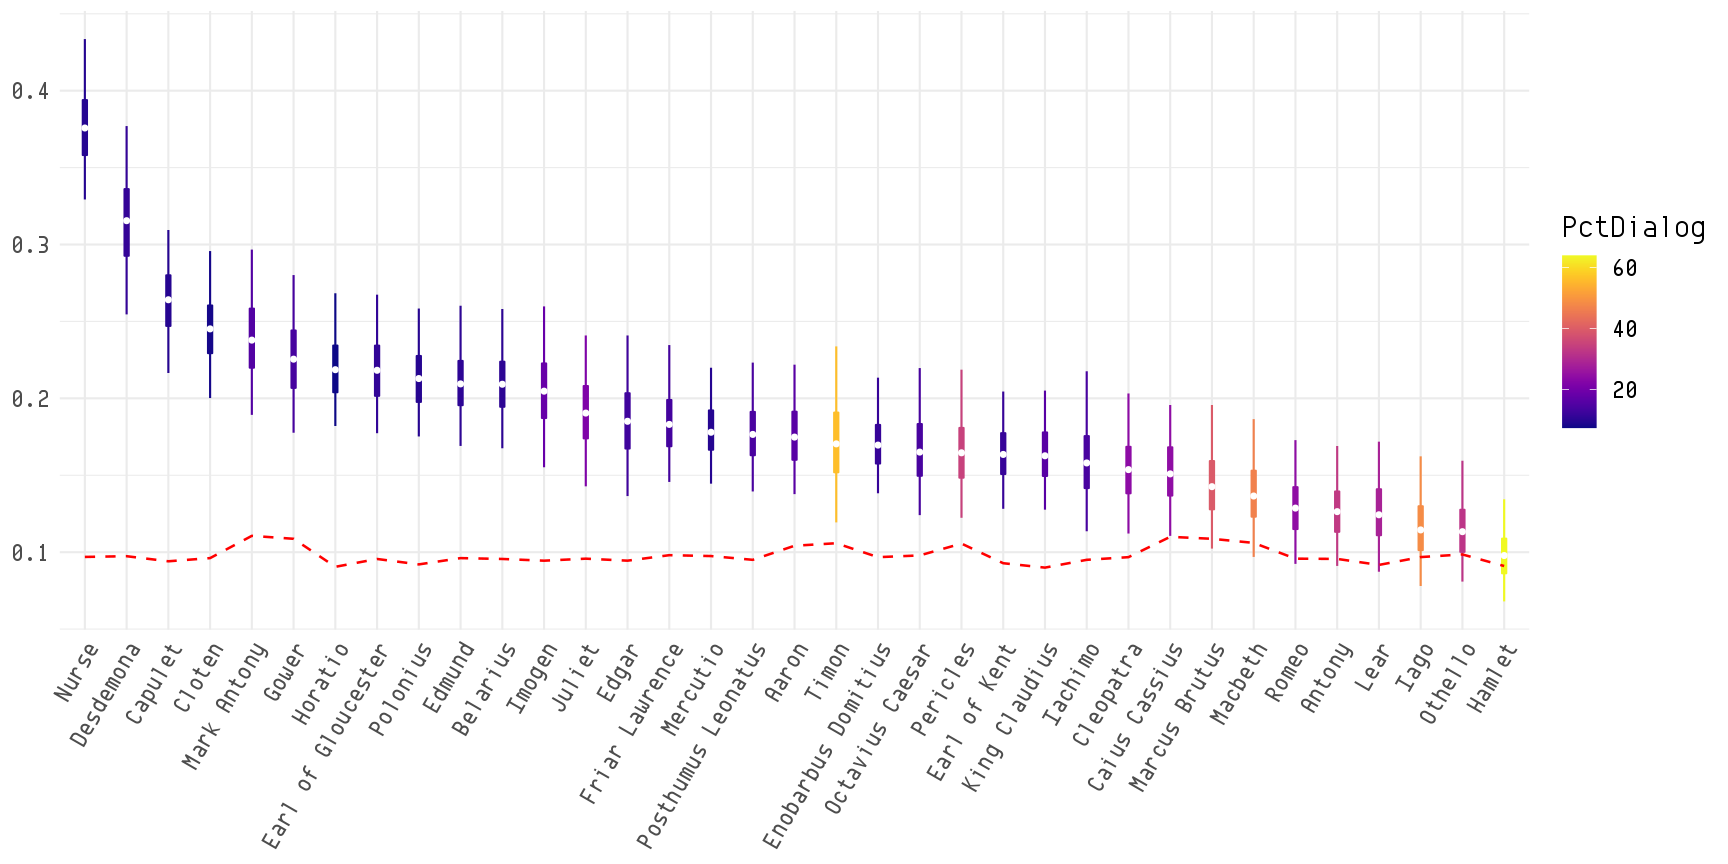

In [16]:
%%R -i wasserstein_df -h 6 -w 12 -u in -r 144
library(ggplot2)
library(viridis)

ggplot(wasserstein_df, aes(x=reorder(Char,-VersusOther50))) +
geom_boxplot(
    aes(
        lower = VersusOther25, 
        upper = VersusOther75, 
        middle = VersusOther50, 
        ymin = VersusOther5, 
        ymax = VersusOther95,
        color=PctDialog,
        fill=PctDialog
    ),
    width = 0.1,
    stat = "identity"
) +
geom_point(aes(y = VersusOther50), color='white', size=1) +
geom_line(aes(y = VersusSelf50,group=1), color='red', size=0.6, linetype='dashed') +
scale_fill_viridis(option='plasma') +
scale_color_viridis(option='plasma',guide='none') +
theme_minimal() +

theme(
    panel.border = element_blank(),
    #legend.position='none',
    axis.title.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.x=element_text(angle = 60, hjust = 1),
    text=element_text(size=15, family="Envy Code R"),
)

In [80]:

SS = SeedSequence(2022)

def bootstrap(a, b, cv, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, cv)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs
@ray.remote
def char_results(char, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = len(set(this_tg))/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/len(other_tg)*100
    # no need to parallelize these as well
    vs_other = bootstrap(this_tg, other_tg, cv, rng)
    vs_self = bootstrap(this_tg, this_tg, cv, rng)

    hsh = {
        'Char':char,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh

df_trim = allstars_long[allstars_long.corpus=='shake']
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    
    # CountVectorizer is threadsafe once fitted (afaik anyway)
    cv.fit([all_threegrams])
    print('='*40)
    print(f"Starting {pn} -- total 3-gram vocab is {len(cv.get_feature_names_out())}, total cast is {len(all)}")

    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.label != allstars.label)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)
        seed = SS.spawn(1)[0]
        # groupby etc is deterministic order, so this should all be reproducible
        rng = default_rng(seed)
        results.append(char_results.remote(r.label, pn, this_char_threegrams, other_chars_threegrams, cv, rng))

energy_df = pd.DataFrame(ray.get(results))



Starting a-midsummer-night-s-dream -- total 3-gram vocab is 3316, total cast is 25
Starting all-s-well-that-ends-well -- total 3-gram vocab is 3422, total cast is 29
Starting antony-and-cleopatra -- total 3-gram vocab is 3514, total cast is 74
Starting as-you-like-it -- total 3-gram vocab is 3353, total cast is 28
Starting coriolanus -- total 3-gram vocab is 3457, total cast is 67
Starting cymbeline -- total 3-gram vocab is 3557, total cast is 41
Starting hamlet -- total 3-gram vocab is 3824, total cast is 38
Starting henry-iv-part-i -- total 3-gram vocab is 3697, total cast is 36
Starting henry-iv-part-ii -- total 3-gram vocab is 3629, total cast is 49
Starting henry-v -- total 3-gram vocab is 3990, total cast is 48
Starting henry-vi-part-1 -- total 3-gram vocab is 3542, total cast is 63
Starting henry-vi-part-2 -- total 3-gram vocab is 3612, total cast is 72
Starting henry-vi-part-3 -- total 3-gram vocab is 3435, total cast is 48
Starting henry-viii -- total 3-gram vocab is 3378, tot

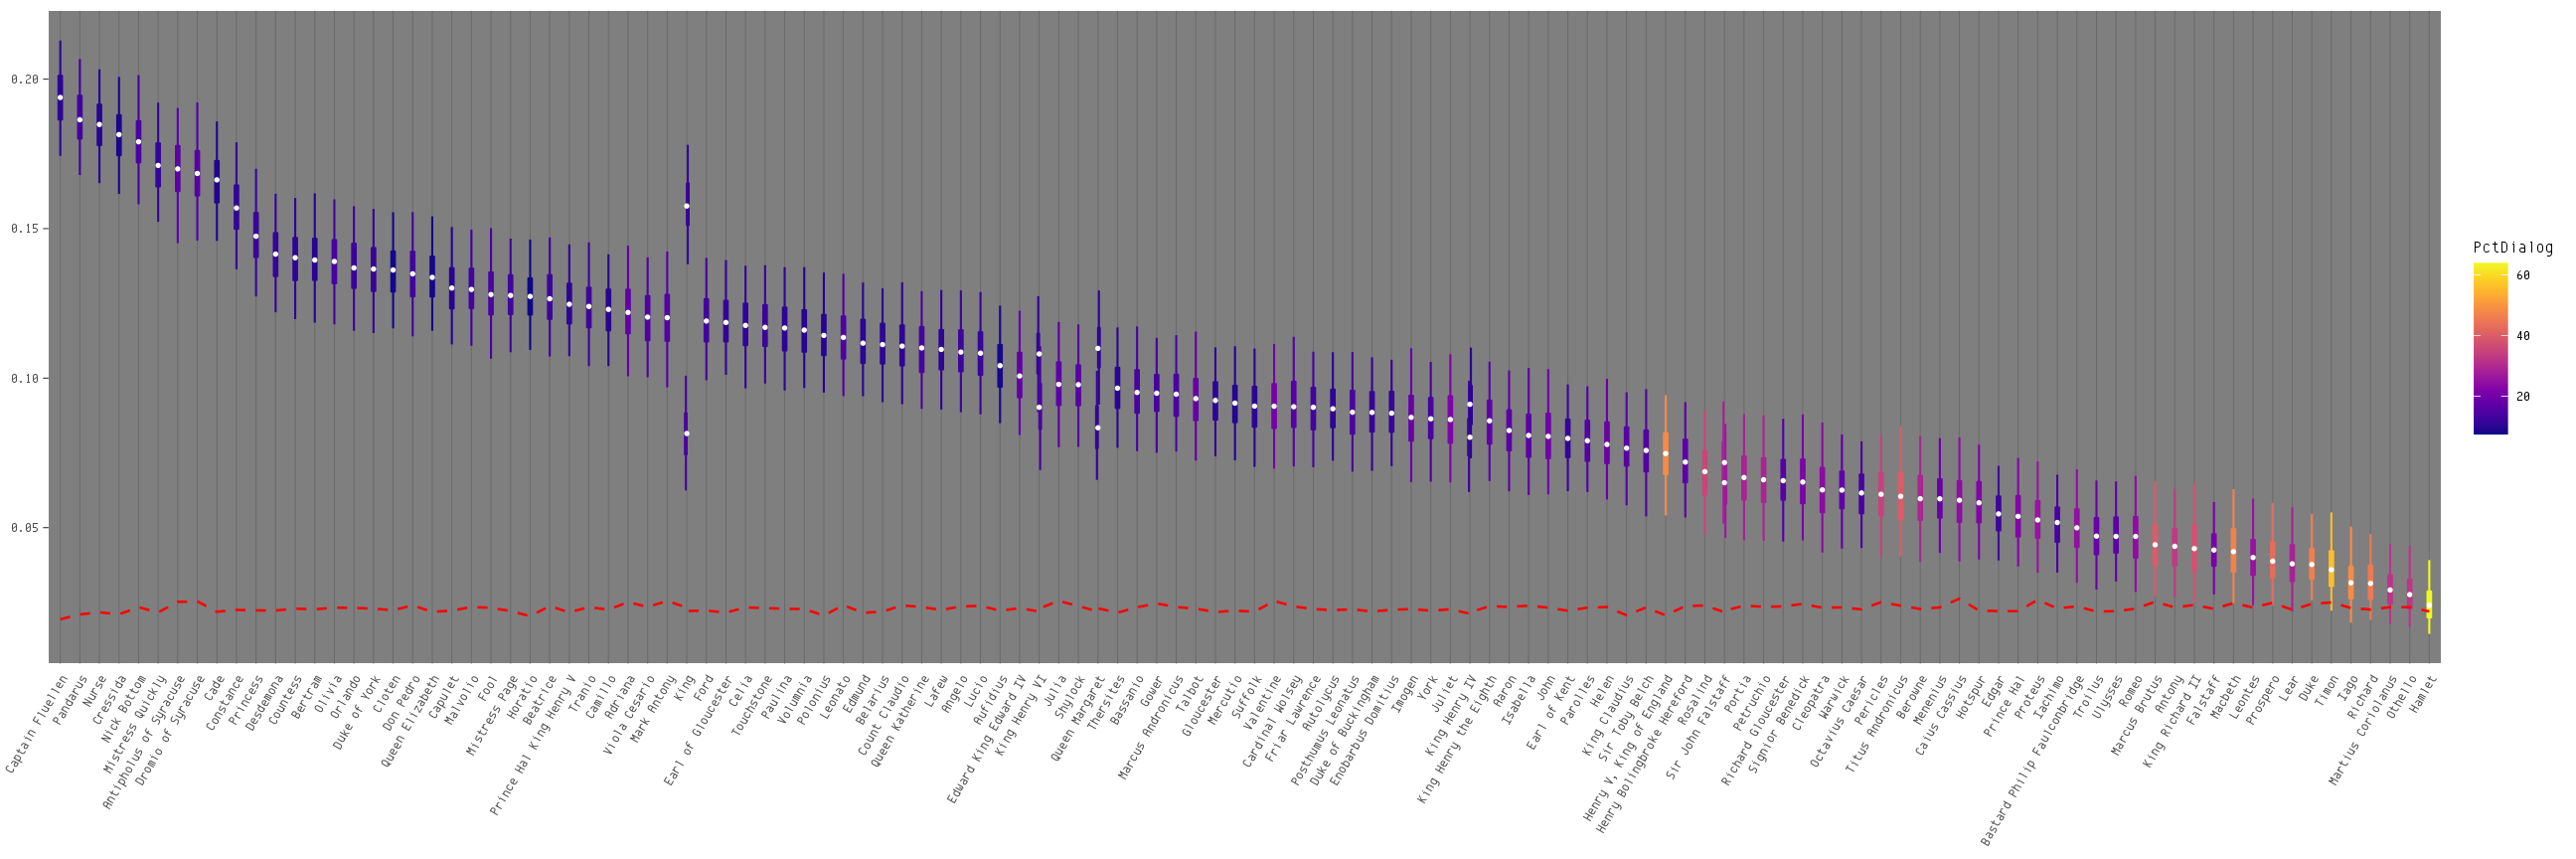

In [88]:
%%R -i energy_df -h 6 -w 18 -u in -r 144
library(ggplot2)
library(viridis)

ggplot(energy_df, aes(x=reorder(Char,-VersusOther50))) +
geom_boxplot(
    aes(
        lower = VersusOther25, 
        upper = VersusOther75, 
        middle = VersusOther50, 
        ymin = VersusOther5, 
        ymax = VersusOther95,
        color=PctDialog,
        fill=PctDialog,
        group=interaction(Char,Play)
    ),
    width = 0.2,
    stat = "identity"
) +
geom_point(aes(y = VersusOther50), color='white', size=0.6) +
geom_line(aes(y = VersusSelf50,group=1), color='red', size=0.6, linetype='dashed') +
scale_fill_viridis(option='plasma') +
scale_color_viridis(option='plasma',guide='none') +
theme_dark() +

theme(
    panel.border = element_blank(),
    #legend.position='none',
    axis.title.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    axis.text.x=element_text(angle = 60, hjust = 1),
    text=element_text(size=8, family="Envy Code R"),
)

In [79]:
df1 = energy_df.copy()
df1

,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95
0,Nick Bottom,a-midsummer-night-s-dream,1661,50.090470,14.066532,0.015935,0.020622,0.023383,0.026634,0.035117,0.158140,0.172162,0.179046,0.185926,0.201329
1,Countess,all-s-well-that-ends-well,1728,50.496786,10.444132,0.015606,0.020043,0.022921,0.026591,0.033139,0.119732,0.132776,0.140264,0.146885,0.160262
2,Bertram,all-s-well-that-ends-well,1717,50.175336,9.833160,0.015094,0.019690,0.022681,0.026164,0.035656,0.118550,0.132838,0.139491,0.146597,0.161802
3,Lafew,all-s-well-that-ends-well,1823,53.272940,10.775688,0.014832,0.019716,0.022492,0.026203,0.034911,0.089488,0.102940,0.109597,0.116089,0.129465
4,Helen,all-s-well-that-ends-well,2105,61.513735,18.778721,0.015408,0.020017,0.023451,0.026872,0.034793,0.059413,0.071573,0.077825,0.085222,0.099803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Olivia,twelfth-night,1785,52.810651,13.630905,0.015396,0.020049,0.023258,0.027077,0.035685,0.117971,0.131716,0.139014,0.146138,0.159792
123,Malvolio,twelfth-night,1765,52.218935,13.141784,0.015532,0.020283,0.023453,0.026739,0.034821,0.110809,0.123423,0.129653,0.136621,0.149644
124,Valentine,two-gentlemen-of-verona,1949,62.870968,20.414375,0.017033,0.021783,0.025465,0.029190,0.038774,0.069749,0.083303,0.090596,0.098028,0.111370
125,Proteus,two-gentlemen-of-verona,2134,68.838710,25.661158,0.016922,0.021964,0.025855,0.030137,0.039613,0.034946,0.046581,0.052564,0.058873,0.072108


In [82]:
# RUN ANALYSIS AGAIN FIRST

df2 = energy_df.copy()
df2

,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95
0,Nick Bottom,a-midsummer-night-s-dream,1661,50.090470,14.066532,0.015935,0.020622,0.023383,0.026634,0.035117,0.158140,0.172162,0.179046,0.185926,0.201329
1,Countess,all-s-well-that-ends-well,1728,50.496786,10.444132,0.015606,0.020043,0.022921,0.026591,0.033139,0.119732,0.132776,0.140264,0.146885,0.160262
2,Bertram,all-s-well-that-ends-well,1717,50.175336,9.833160,0.015094,0.019690,0.022681,0.026164,0.035656,0.118550,0.132838,0.139491,0.146597,0.161802
3,Lafew,all-s-well-that-ends-well,1823,53.272940,10.775688,0.014832,0.019716,0.022492,0.026203,0.034911,0.089488,0.102940,0.109597,0.116089,0.129465
4,Helen,all-s-well-that-ends-well,2105,61.513735,18.778721,0.015408,0.020017,0.023451,0.026872,0.034793,0.059413,0.071573,0.077825,0.085222,0.099803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Olivia,twelfth-night,1785,52.810651,13.630905,0.015396,0.020049,0.023258,0.027077,0.035685,0.117971,0.131716,0.139014,0.146138,0.159792
123,Malvolio,twelfth-night,1765,52.218935,13.141784,0.015532,0.020283,0.023453,0.026739,0.034821,0.110809,0.123423,0.129653,0.136621,0.149644
124,Valentine,two-gentlemen-of-verona,1949,62.870968,20.414375,0.017033,0.021783,0.025465,0.029190,0.038774,0.069749,0.083303,0.090596,0.098028,0.111370
125,Proteus,two-gentlemen-of-verona,2134,68.838710,25.661158,0.016922,0.021964,0.025855,0.030137,0.039613,0.034946,0.046581,0.052564,0.058873,0.072108


In [89]:
# OK seems like we have reproducible results

(df1.VersusSelf50 - df1.VersusSelf50).sum()

0.0

In [87]:
energy_df.to_pickle('shakespeare_energy_dists.pkl.zip')

In [93]:

SS = SeedSequence(2022)

def bootstrap(a, b, cv, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, cv)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs
@ray.remote
def char_results(char, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = len(set(this_tg))/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/len(other_tg)*100
    # no need to parallelize these as well
    vs_other = bootstrap(this_tg, other_tg, cv, rng)
    vs_self = bootstrap(this_tg, this_tg, cv, rng)

    hsh = {
        'Char':char,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh

df_trim = allstars_long[allstars_long.corpus=='fre']
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    
    # CountVectorizer is threadsafe once fitted (afaik anyway)
    cv.fit([all_threegrams])
    print('='*40)
    print(f"Starting {pn} -- total 3-gram vocab is {len(cv.get_feature_names_out())}, total cast is {len(all)}")
    if len(all) < 2:
        print("[*] WHOOPS! Not enough characters. Skipping.")
        continue
              
    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.label != allstars.label)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)
        seed = SS.spawn(1)[0]
        # groupby etc is deterministic order, so this should all be reproducible
        rng = default_rng(seed)
        results.append(char_results.remote(r.label, pn, this_char_threegrams, other_chars_threegrams, cv, rng))


energy_df_fr = pd.DataFrame(ray.get(results))



Starting abeille-argelie -- total 3-gram vocab is 2674, total cast is 8
Starting abeille-coriolan -- total 3-gram vocab is 2652, total cast is 7
Starting abeille-lyncee -- total 3-gram vocab is 2602, total cast is 7
Starting allainval-ecole-des-bourgeois -- total 3-gram vocab is 2697, total cast is 13
Starting ancelot-arago-papillotes -- total 3-gram vocab is 2558, total cast is 16
Starting ancelot-auger-une-seduction -- total 3-gram vocab is 2690, total cast is 8
Starting anomyme-dialogue-de-la-prude-et-de-la-coquette -- total 3-gram vocab is 1873, total cast is 2
Starting anonyme-adam -- total 3-gram vocab is 2726, total cast is 18
Starting anonyme-matinee-comedien-francais -- total 3-gram vocab is 2439, total cast is 5
Starting archambault-ce-n-est-pas -- total 3-gram vocab is 2246, total cast is 11
Starting archambault-hurlubrelu -- total 3-gram vocab is 2425, total cast is 14
Starting archambault-janot-battus -- total 3-gram vocab is 2223, total cast is 10
Starting archambault-joc

In [90]:
allstars_long.corpus.unique()

array(['rus', 'fre', 'ger', 'shake'], dtype=object)

In [94]:
energy_df_fr

,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95
0,Argélie,abeille-argelie,2074,77.561705,34.249486,0.019432,0.025441,0.029758,0.034898,0.045001,0.029189,0.040118,0.045887,0.052447,0.064864
1,Phoenix,abeille-argelie,1821,68.100224,24.766003,0.019746,0.025320,0.029151,0.033466,0.042376,0.082701,0.097437,0.105794,0.114523,0.129362
2,Ismene,abeille-argelie,2087,78.047868,44.289719,0.019561,0.025342,0.029674,0.034259,0.045893,0.036968,0.048697,0.055328,0.063262,0.079746
3,C. Martius,abeille-coriolan,2200,82.956259,57.184065,0.019637,0.025785,0.029700,0.034715,0.046794,0.023257,0.031067,0.036722,0.042009,0.053667
4,Virgile,abeille-coriolan,1718,64.781297,23.170314,0.019491,0.025407,0.029120,0.033819,0.044335,0.090636,0.104661,0.113301,0.121832,0.135552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,Madeleine,zola-madeleine,1674,71.112999,62.007448,0.021844,0.028522,0.032851,0.037700,0.048354,0.095180,0.112378,0.122315,0.132186,0.149318
1739,Laurent,zola-therese-raquin,1955,63.268608,21.856271,0.017234,0.022082,0.025326,0.029632,0.039088,0.052639,0.064709,0.071702,0.079115,0.094412
1740,Therese,zola-therese-raquin,2052,66.407767,26.718371,0.017259,0.021729,0.025326,0.029710,0.039227,0.043375,0.055263,0.063169,0.071330,0.085336
1741,Madame Raquin,zola-therese-raquin,1735,56.148867,17.367044,0.017112,0.021738,0.024951,0.029025,0.037097,0.110791,0.124850,0.132653,0.140886,0.155683


In [95]:
energy_df_fr.to_pickle('fre_energy_dists.pkl.zip')

In [96]:
energy_df_fr.VersusSelf50.describe()

count    1743.000000
mean        0.028002
std         0.002440
min         0.017682
25%         0.026617
50%         0.028093
75%         0.029287
max         0.039911
Name: VersusSelf50, dtype: float64

In [97]:
energy_df.VersusSelf50.describe()

count    127.000000
mean       0.022983
std        0.001203
min        0.019355
25%        0.022204
50%        0.022950
75%        0.023635
max        0.026238
Name: VersusSelf50, dtype: float64

In [98]:
energy_df_fr.VocabSz.describe()

count    1743.000000
mean     1927.216867
std       222.148028
min      1439.000000
25%      1772.000000
50%      1887.000000
75%      2044.000000
max      3505.000000
Name: VocabSz, dtype: float64

In [99]:
energy_df.VocabSz.describe()

count     127.000000
mean     2069.133858
std       300.792112
min      1616.000000
25%      1830.500000
50%      2005.000000
75%      2261.000000
max      3190.000000
Name: VocabSz, dtype: float64

In [100]:

SS = SeedSequence(2022)

def bootstrap(a, b, cv, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, cv)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs
@ray.remote
def char_results(char, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = len(set(this_tg))/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/len(other_tg)*100
    # no need to parallelize these as well
    vs_other = bootstrap(this_tg, other_tg, cv, rng)
    vs_self = bootstrap(this_tg, this_tg, cv, rng)

    hsh = {
        'Char':char,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh

df_trim = allstars_long[allstars_long.corpus=='ger']
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    
    # CountVectorizer is threadsafe once fitted (afaik anyway)
    cv.fit([all_threegrams])
    print('='*40)
    print(f"Starting {pn} -- total 3-gram vocab is {len(cv.get_feature_names_out())}, total cast is {len(all)}")
    if len(all) < 2:
        print("[*] WHOOPS! Not enough characters. Skipping.")
        continue
              
    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.label != allstars.label)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)
        seed = SS.spawn(1)[0]
        # groupby etc is deterministic order, so this should all be reproducible
        rng = default_rng(seed)
        results.append(char_results.remote(r.label, pn, this_char_threegrams, other_chars_threegrams, cv, rng))


energy_df_ger = pd.DataFrame(ray.get(results))



Starting alberti-brot -- total 3-gram vocab is 3905, total cast is 48
Starting alberti-im-suff -- total 3-gram vocab is 3240, total cast is 14
Starting andre-der-comoedienfeind -- total 3-gram vocab is 2302, total cast is 6
Starting anzengruber-der-gwissenswurm -- total 3-gram vocab is 3100, total cast is 15
Starting anzengruber-der-meineidbauer -- total 3-gram vocab is 3529, total cast is 22
Starting anzengruber-der-pfarrer-von-kirchfeld -- total 3-gram vocab is 3667, total cast is 21
Starting anzengruber-die-kreuzelschreiber -- total 3-gram vocab is 3249, total cast is 23
Starting anzengruber-heimgfunden -- total 3-gram vocab is 3905, total cast is 29
Starting arnim-halle -- total 3-gram vocab is 4298, total cast is 81
Starting arnim-jerusalem -- total 3-gram vocab is 3833, total cast is 72
Starting arnim-marino-caboga -- total 3-gram vocab is 3323, total cast is 22
Starting auenbrugger-der-rauchfangkehrer -- total 3-gram vocab is 3463, total cast is 20
Starting avenarius-faust -- to

In [101]:
energy_df_ger

,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95
0,Gerlind,alberti-brot,2078,53.213828,15.049436,0.013541,0.017690,0.020371,0.023946,0.031622,0.060109,0.070923,0.077106,0.083432,0.095958
1,Münzer,alberti-brot,2898,74.212548,56.495564,0.014017,0.017556,0.020640,0.024197,0.033053,0.016722,0.023019,0.027822,0.032894,0.044517
2,Krawutschke,alberti-im-suff,1973,60.895062,44.291571,0.015990,0.020942,0.024630,0.028596,0.037523,0.106338,0.121969,0.129781,0.137463,0.151866
3,Oront,andre-der-comoedienfeind,1714,74.456994,77.132982,0.022371,0.028815,0.033117,0.038464,0.049530,0.037349,0.050987,0.059009,0.066138,0.083699
4,Grillhofer,anzengruber-der-gwissenswurm,2124,68.516129,40.399773,0.016436,0.021964,0.025555,0.029768,0.038796,0.044051,0.057041,0.064506,0.072674,0.087302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,Abellino,zschokke-abellino,2522,59.621749,15.907860,0.013000,0.016670,0.019472,0.022867,0.029821,0.036873,0.047191,0.053691,0.059454,0.070505
1165,Doge,zschokke-abellino,2730,64.539007,24.717782,0.012375,0.016629,0.019391,0.022744,0.030755,0.036480,0.047482,0.054075,0.060344,0.073666
1166,Rosamunde,zschokke-abellino,2079,49.148936,11.293454,0.012652,0.016345,0.019071,0.022015,0.028592,0.103964,0.115337,0.121600,0.127415,0.140792
1167,Flodoardo,zschokke-abellino,2303,54.444444,14.533227,0.012420,0.016317,0.018705,0.021713,0.030671,0.080102,0.092591,0.099381,0.106004,0.119308


In [102]:
energy_df_ger.to_pickle('ger_energy_dists.pkl.zip')

In [103]:

SS = SeedSequence(2022)

def bootstrap(a, b, cv, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, cv)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs
@ray.remote
def char_results(char, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = len(set(this_tg))/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/len(other_tg)*100
    # no need to parallelize these as well
    vs_other = bootstrap(this_tg, other_tg, cv, rng)
    vs_self = bootstrap(this_tg, this_tg, cv, rng)

    hsh = {
        'Char':char,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh

df_trim = allstars_long[allstars_long.corpus=='rus']
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    
    # CountVectorizer is threadsafe once fitted (afaik anyway)
    cv.fit([all_threegrams])
    print('='*40)
    print(f"Starting {pn} -- total 3-gram vocab is {len(cv.get_feature_names_out())}, total cast is {len(all)}")
    if len(all) < 2:
        print("[*] WHOOPS! Not enough characters. Skipping.")
        continue
              
    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.label != allstars.label)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)
        seed = SS.spawn(1)[0]
        # groupby etc is deterministic order, so this should all be reproducible
        rng = default_rng(seed)
        results.append(char_results.remote(r.label, pn, this_char_threegrams, other_chars_threegrams, cv, rng))


energy_df_rus = pd.DataFrame(ray.get(results))



Starting afinogenov-mashenka -- total 3-gram vocab is 4365, total cast is 12
Starting andreyev-k-zvezdam -- total 3-gram vocab is 4490, total cast is 13
Starting andreyev-mysl -- total 3-gram vocab is 3993, total cast is 15
Starting andreyev-ne-ubiy -- total 3-gram vocab is 4642, total cast is 23
Starting artsybashev-revnost -- total 3-gram vocab is 4156, total cast is 11
Starting bulgakov-adam-i-eva -- total 3-gram vocab is 4760, total cast is 13
Starting bulgakov-batum -- total 3-gram vocab is 4454, total cast is 36
Starting bulgakov-beg -- total 3-gram vocab is 4723, total cast is 40
Starting bulgakov-dni-turbinyh -- total 3-gram vocab is 5104, total cast is 29
Starting bulgakov-ivan-vasilevich -- total 3-gram vocab is 4284, total cast is 16
Starting bulgakov-vojna-i-mir -- total 3-gram vocab is 5209, total cast is 95
Starting bulgakov-zojkina-kvartira -- total 3-gram vocab is 5033, total cast is 27
Starting chekhov-chaika -- total 3-gram vocab is 4557, total cast is 12
Starting che

In [104]:
energy_df_rus

,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95
0,Окаемов,afinogenov-mashenka,3103,71.088202,44.072222,0.011869,0.016431,0.019509,0.023260,0.031515,0.023645,0.033894,0.039225,0.045460,0.057197
1,Инна Александровна,andreyev-k-zvezdam,2347,52.271715,20.852772,0.011675,0.015609,0.018377,0.021570,0.028386,0.151051,0.164087,0.170646,0.176515,0.190349
2,Керженцев,andreyev-mysl,3035,76.008014,71.412674,0.013119,0.017962,0.020929,0.024691,0.033107,0.024053,0.033823,0.040217,0.046021,0.058123
3,Яков,andreyev-ne-ubiy,2542,54.760879,20.515114,0.011744,0.015390,0.017817,0.020810,0.028469,0.119034,0.130897,0.137061,0.143217,0.156178
4,Василиса Петровна,andreyev-ne-ubiy,3248,69.969841,51.907796,0.011161,0.015239,0.018101,0.021538,0.029361,0.086871,0.099882,0.106587,0.114253,0.126981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,Дарья Ивановна,turgenev-provintsialka,2671,70.924057,69.115613,0.014240,0.019067,0.022254,0.026394,0.035968,0.043557,0.055144,0.062524,0.069706,0.084174
244,Граф Любин,turgenev-provintsialka,2649,70.339883,47.214845,0.014476,0.019309,0.022669,0.026532,0.036074,0.024092,0.033131,0.037788,0.042515,0.053327
245,Балагалаев,turgenev-zavtrak-u-predvoditelja,2299,69.540230,55.897524,0.016108,0.021465,0.025177,0.029736,0.039028,0.078605,0.091427,0.099433,0.107607,0.121605
246,Любский,zagoskin-blagorodnyj-teatr,2552,60.018815,22.910222,0.012320,0.016597,0.019811,0.023287,0.031158,0.098597,0.109916,0.116504,0.123442,0.137374


In [ ]:
energy_df_g.to_pickle('ger_energy_dists.pkl.zip')